In [ ]:
!wget -O tiny-imagenet-c.tar "https://zenodo.org/records/2536630/files/Tiny-ImageNet-C.tar?download=1"

In [ ]:
!tar -xvf tiny-imagenet-c.tar

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
DATA_DIR = '/content/Tiny-ImageNet-C'

BATCH_SIZE = 64
EPOCHS = 10
LR = 1e-3
IMG_SIZE = 64
NUM_CLASSES = 15  # Number of corruption types

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# This should return 'cuda', if not go to 'Runtime' -> 'Change runtime type' -> Select GPU
print("Using device:", DEVICE)

Using device: cuda


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os

class CorruptionTypeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.labels = []
        self.transform = transform
        self.label_map = {}

        corruption_types = sorted([
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ])

        for idx, corruption in enumerate(corruption_types):
            self.label_map[corruption] = idx
            for severity in range(1, 6):
                severity_path = os.path.join(root_dir, corruption, str(severity))
                if not os.path.isdir(severity_path):
                    continue

                for class_folder in os.listdir(severity_path):
                    class_dir = os.path.join(severity_path, class_folder)
                    if not os.path.isdir(class_dir):
                        continue

                    for img_file in os.listdir(class_dir):
                        if img_file.endswith('.JPEG'):
                            img_path = os.path.join(class_dir, img_file)
                            self.samples.append(img_path)
                            self.labels.append(idx)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img = Image.open(self.samples[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

In [18]:
from torch.utils.data import random_split

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    normalize,
])

dataset = CorruptionTypeDataset(DATA_DIR, transform=None)
generator = torch.Generator().manual_seed(42)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

print(f"Total images loaded: {len(dataset)}")
print(f"Classes: {dataset.label_map}")
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Total images loaded: 750000
Classes: {'brightness': 0, 'contrast': 1, 'defocus_blur': 2, 'elastic_transform': 3, 'fog': 4, 'frost': 5, 'gaussian_noise': 6, 'glass_blur': 7, 'impulse_noise': 8, 'jpeg_compression': 9, 'motion_blur': 10, 'pixelate': 11, 'shot_noise': 12, 'snow': 13, 'zoom_blur': 14}
Train: 600000 | Val: 75000 | Test: 75000


In [19]:
model = models.resnet18(weights='DEFAULT')
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [21]:
train_loss_history = []
val_loss_history = []
val_acc_history = []
test_loss_history = []
test_acc_history = []
all_preds = []
all_labels = []

best_val_accuracy = 0
patience = 3           # number of epochs to wait for improvement
patience_counter = 0
early_stop = False

save_path = "best_model.pth"

for epoch in range(EPOCHS):
    # Training
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_loss_history.append(avg_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(val_accuracy)
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy*100:.2f}%")
    # Early Stopping Feature(overfitting)
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
        print(f"🔥 New best model saved! Val Acc: {val_accuracy*100:.2f}%")
    else:
        patience_counter += 1
        print(f"⏳ No improvement. Patience: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print("🛑 Early stopping triggered.")
        break

# Testing
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct / total
test_loss_history.append(avg_test_loss)
test_acc_history.append(test_accuracy)
print(f"Test Loss: {avg_test_loss:.4f} | 🧪 Test Accuracy: {test_accuracy*100:.2f}%")

Epoch 1/10, Train Loss: 0.3292 | Val Loss: 0.1877 | Val Acc: 93.38%
🔥 New best model saved! Val Acc: 93.38%
Epoch 2/10, Train Loss: 0.1734 | Val Loss: 0.1465 | Val Acc: 94.73%
🔥 New best model saved! Val Acc: 94.73%
Epoch 3/10, Train Loss: 0.1250 | Val Loss: 0.1230 | Val Acc: 95.38%
🔥 New best model saved! Val Acc: 95.38%
Epoch 4/10, Train Loss: 0.0972 | Val Loss: 0.1213 | Val Acc: 95.46%
🔥 New best model saved! Val Acc: 95.46%
Epoch 5/10, Train Loss: 0.0783 | Val Loss: 0.0934 | Val Acc: 96.56%
🔥 New best model saved! Val Acc: 96.56%
Epoch 6/10, Train Loss: 0.0637 | Val Loss: 0.0971 | Val Acc: 96.45%
⏳ No improvement. Patience: 1/3
Epoch 7/10, Train Loss: 0.0556 | Val Loss: 0.0845 | Val Acc: 97.03%
🔥 New best model saved! Val Acc: 97.03%
Epoch 8/10, Train Loss: 0.0482 | Val Loss: 0.0703 | Val Acc: 97.41%
🔥 New best model saved! Val Acc: 97.41%
Epoch 9/10, Train Loss: 0.0410 | Val Loss: 0.0635 | Val Acc: 97.79%
🔥 New best model saved! Val Acc: 97.79%
Epoch 10/10, Train Loss: 0.0388 | Va

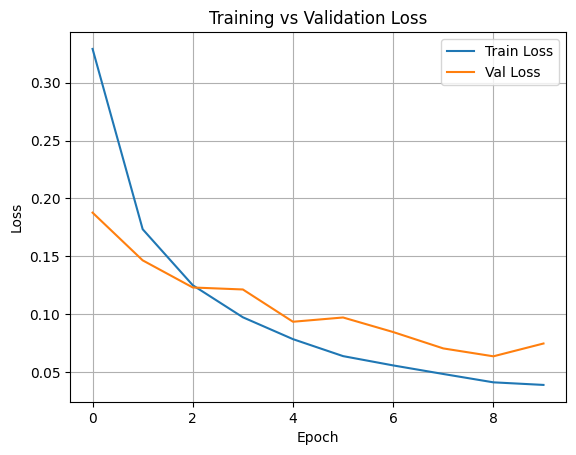

In [22]:
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

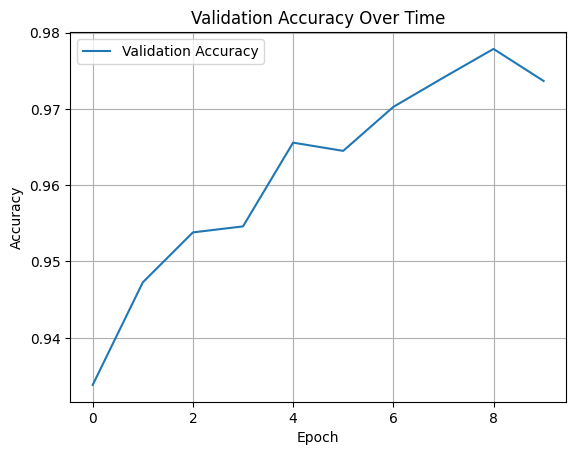

In [23]:
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Time')
plt.legend()
plt.grid(True)
plt.show()

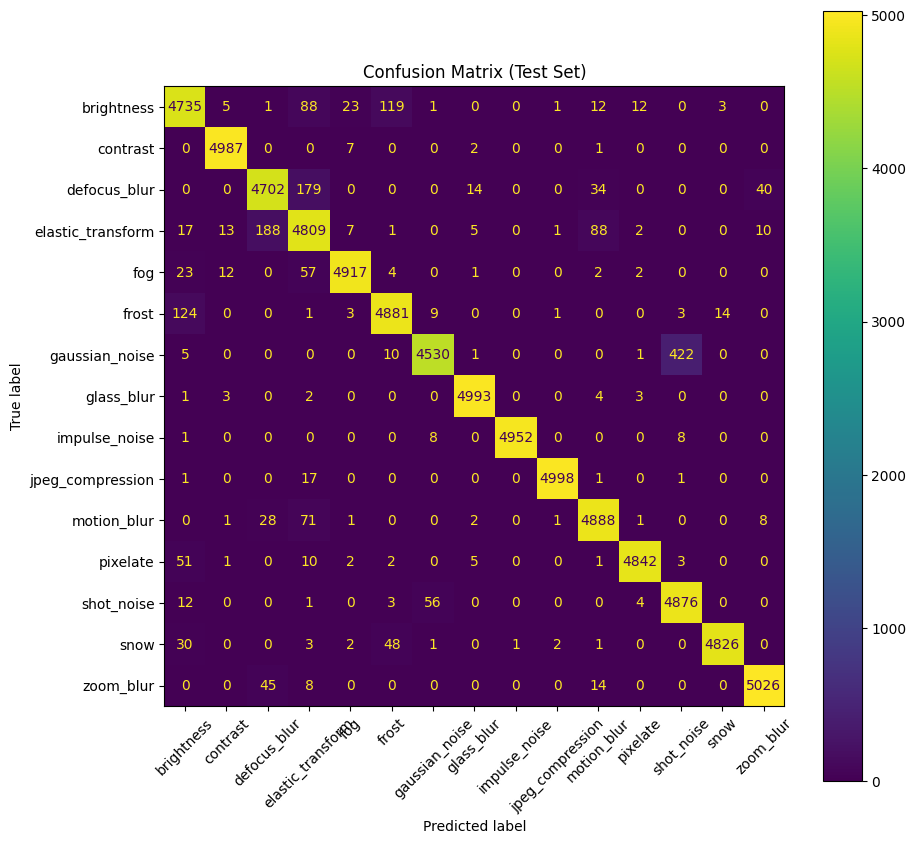

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.label_map.keys())
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix (Test Set)")
plt.show()